### Dataprep

In [18]:
# Libraries
import jax
import jax.numpy as jnp
import gymnax
from gymnax.environments import environment, spaces
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Constant stock price')

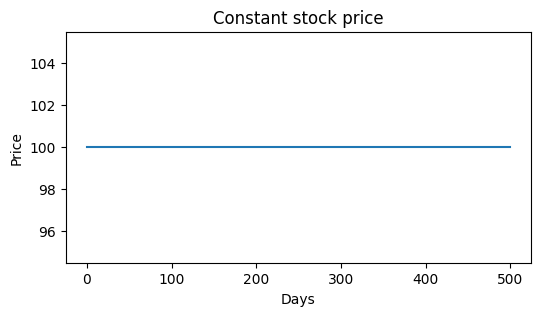

In [18]:
# constant price
data = jnp.array([jnp.arange(500), jnp.repeat(100,500)])
plt.figure(figsize=(6,3))
plt.plot(data[0],data[1])
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Constant stock price")

In [70]:
class TradingSimulator:
    
    def __init__(self, trading_days, training):
        
        self.trading_days = jnp.int32(trading_days)
        self.counter = jnp.int32(0)
        self.done = jnp.bool(False)
        self.stock_price = jnp.array([100.,100.,100.,100.,100.])
        
        self.training = jnp.bool(training)
        self.states = self.stock_price
        self.actions = jnp.array([0, 0, 0, 0, 0], dtype=jnp.int32)
        self.rewards = jnp.array([0.,0.,0.,0.,0.])
        
        self.reward = jnp.float32
        self.curr_action = jnp.int32
        self.curr_state = jnp.float32
    
    def take_step(self, action):
        # curr_state will be used in a later stage.
        self.curr_action = action
        ## REWARD
        if self.curr_action != self.actions[-1]:
            self.reward = 0.05
        else: 
            self.reward = -0.05
        # Add reward
        self.rewards = jnp.concatenate([self.rewards, jnp.array([self.reward])])
        ## REWARD
        ## Change in stock price
        if self.curr_action == 1:       
            self.states = jnp.concatenate([self.states, jnp.array([self.states[-1] + 5.])])
        else:
            self.states = jnp.concatenate([self.states, jnp.array([self.states[-1] - 5.])])
        ## Add action
        self.actions = jnp.concatenate([self.actions, jnp.array([self.curr_action])])

        self.counter += 1

        info = {'reward': self.reward}
        return self.reward, info
    
    def status(self):
        if self.counter == self.trading_days:
            self.done = True
        return self.states[-5:], self.done
    
    def reset(self, training):
        self.training = training
        self.counter = 0
        self.done = False
        self.states = self.stock_price
        self.actions = jnp.array([0, 0, 0, 0, 0], dtype=jnp.int32)
        self.rewards = jnp.array([0.,0.,0.,0.,0.])

    def result(self):
        result = {}
        result['states'] = self.states
        result['actions'] = self.actions
        result['rewards'] = self.rewards
        return result

In [71]:
class TradingEnvironment(environment.Environment):
    
    def __init__(self, trading_days, training):
        
        self.trading_days = jnp.int32(trading_days)
        self.training = jnp.bool(training)
        # Trading Simulator
        self.simulator = TradingSimulator(trading_days=self.trading_days, training=self.training)
        # Action Space (0,1)
        self.action_space = spaces.Discrete(2)
        # Feature Space
        self.num_features = 5
        # Observation Space
        self.observation_space = spaces.Box(low=-jnp.inf, high=jnp.inf, shape=(self.num_features,), dtype=jnp.float32)
    
    def step(self, action):
       assert action in [0, 1], '{} {} invalid'.format(action, type(action))
       reward, info = self.simulator.take_step(action)
       observation, done = self.simulator.status()
       return observation, reward, done, info
    
    def reset(self, rng_key, training):
        #rng_key, subkey = jax.random.split(rng_key)
        self.simulator.reset(training=self.training)
        observation, done = self.simulator.status()
        return observation, done
    
    def action_space(self):
        return self.action_space

    def observation_space(self):
        return self.observation_space

    def get_state(self):
        # Placeholder for returning the current environment state
        pass
        

In [43]:
a = jnp.array([1,2,3,4.])

a = jnp.concatenate([a,jnp.array([a[-1] + 1])])
print(a)

[1. 2. 3. 4. 5.]


In [72]:
abc = TradingEnvironment(trading_days=252, training=False)
print(abc.simulator.status()[0])
print("")
observation, reward, done, info = abc.step(action=0)
print(observation)
print(reward)
print(done)
print(info)
print(abc.simulator.rewards)
print("")
observation, reward, done, info = abc.step(action=0)
print(observation)
print(reward)
print(done)
print(info)
print(abc.simulator.rewards)
print("")
observation, reward, done, info = abc.step(action=1)
print(observation)
print(reward)
print(done)
print(info)
print(abc.simulator.rewards)



[100. 100. 100. 100. 100.]

[100. 100. 100. 100.  95.]
-0.05
False
{'reward': -0.05}
[ 0.    0.    0.    0.    0.   -0.05]

[100. 100. 100.  95.  90.]
-0.05
False
{'reward': -0.05}
[ 0.    0.    0.    0.    0.   -0.05 -0.05]

[100. 100.  95.  90.  95.]
0.05
False
{'reward': 0.05}
[ 0.    0.    0.    0.    0.   -0.05 -0.05  0.05]
